In [1]:
# @markdown 
%%HTML
<h1 color='yellow'>scClass: A immune cell classifier tool created by supervised deep learning</h1><br>
<table width="100%" border="0" style="font-size: 16px;">
      <td style="width:18%;" align="center">
        <img src="https://raw.githubusercontent.com/majaja068/scRNA-CellType-classifier/main/pic/Pngtree_red_blood_cell_and_white.png" height="160" align="center"><br>
        <p align="center">Logo <a href="https://pngtree.com/so/Red" >from</a></p>
     </td>
     <td align="left">
        <a href="https://colab.research.google.com/drive/1aKaPxYEgtCNlprYR8b6U4zInw-OQvntv#scrollTo=KV1E3pHrGZBp"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a>
       <br><br>
<li>This notebook provides a scRNA-tool to classify immune cells</li><br>
<li>we choose PBMC <a href="https://www.sciencedirect.com/science/article/pii/S0092867421005833">multimodal single-cell data</a>in default to demo.</li><br>
<li><strong>For more infromation, see the source code on <a href="https://github.com/majaja068/scRNA-CellType-classifier">scClass GitHub. </strong></li><br>
    </td>
</table>

In [2]:
#@title <font color='yellow'>Input the URL of scRNA dataset

URL = "https://atlas.fredhutch.org/data/nygc/multimodal/pbmc_multimodal.h5seurat" #@param {type:"string"}
# https://cblast.gao-lab.org/Zheng/Zheng.h5
filename = URL.split('/')[-1]
try:
  open(filename)
except:
  !wget {URL}
  from IPython.display import clear_output; clear_output()

In [3]:
#@title <font color='yellow'>Install scClass package</font>
import pandas as pd

url = "https://raw.githubusercontent.com/majaja068/scRNA-CellType-classifier/main/scClass_version.txt"
scClass_version = pd.read_csv(url)
FILEID = scClass_version['id'][0]
FILENAME = "scClass.tar.gz"
try:
  import scClass
except:
  !gdown --id {FILEID} -O {FILENAME}
  !pip install scClass.tar.gz
  from IPython.display import clear_output; clear_output()

In [4]:
#@title <font color='yellow'>Reading File</font>

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import anndata as ad
import warnings; warnings.filterwarnings('ignore')
# scClass
import scClass
from scClass.main import Model

def read_h5seurat(filename):
  import h5py
  import scanpy as sc
  from scipy import sparse
  import pandas as pd
  ds = h5py.File(filename, 'r')
  m=ds['assays/SCT/counts']
  def get_loop(dir):
    re = {}
    for k in ds[dir].keys():
      if k!='_index':
        re[k] = ds[dir][k][:].astype(str)
    return re 
  def get_once(dir):
    return ds[dir][:].astype(str)
  ad=sc.AnnData(
      X = sparse.csr_matrix((m['data'][:],m['indices'][:],m['indptr'][:])),
      obs = pd.DataFrame(get_loop('meta.data'),index=get_once('meta.data/_index')),
      var = pd.DataFrame(get_once('assays/SCT/features'),columns=['Gene'])
  )
  return ad

adata = read_h5seurat(filename)
adata  


AnnData object with n_obs × n_vars = 161764 × 20729
    obs: 'Phase', 'celltype.l1', 'celltype.l2', 'celltype.l3', 'donor', 'lane', 'nCount_ADT', 'nCount_RNA', 'nCount_SCT', 'nFeature_ADT', 'nFeature_RNA', 'nFeature_SCT', 'orig.ident', 'time'
    var: 'Gene'

In [5]:
#@title <font color='yellow'>Choose the cell type label</font>
import ipywidgets as widgets
from IPython.display import display
w = widgets.Dropdown(
    options=list(adata.obs.keys()),
    value='celltype.l2',
    description='Label：',
    )
button = widgets.Button(
    description="Confirm",
    )

def on_button_clicked(change):
  label_name = w.value
  # print('label_name = ',label_name)

button.on_click(on_button_clicked)
form = widgets.Box(
  [w,button],
  layout=widgets.Layout(flex_flow='row')
)
display(form)
label_name = w.value

Box(children=(Dropdown(description='Label：', index=2, options=('Phase', 'celltype.l1', 'celltype.l2', 'celltyp…

In [6]:
#@title <font color='yellow'>Data Preparation</font>

# Transmodel(gene seq)
gene = adata.var['Gene'].values
adata = scClass.transmodel(adata,gene=gene,gene_ref="Gene",ram=8)
adata = scClass.norm_by_sf(adata=adata,sf='simple')

get gene seq...
0% 24% 48% 72% 96% 
Of 20729 genes in the input file, 20279 were found in the training set of 45468 genes.
mapping to model...
0% 9% 18% 27% 37% 46% 55% 64% 74% 83% 92% 

loading model from:  /usr/local/lib/python3.7/dist-packages/scClass/data/model_train_v2.pkl
0% 6% 12% 18% 24% 30% 37% 43% 49% 55% 61% 68% 74% 80% 86% 92% 98% 

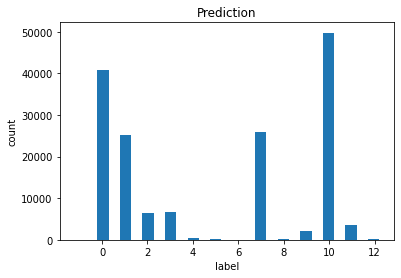

label stored in: './output/cell_type_20210928_121837.csv'


In [7]:
#@title <font color='yellow'>Classify</font>

save_path = None #@param {type:"string"}

model = scClass.load()
scClass.main.threshold = [np.NAN]*13
y_pred = scClass.main.predict_batch(adata,model,batch_size=10_000)
scClass.save_predict(y_pred,path=save_path)

In [8]:
#@title <font color='yellow'>Auto Transfer label</font>
key = [
['cd4','reg'],
['cd8'],
['memory','intermediate'],
['naive','b cell'],
['plasma'],
['pre'],
['pro'],
['nk'],
['ery'],
['meg','platelet'],
['mono'],
['dc'],
['hs'],
]
index2label = np.array(['T-helper cell','cytotoxic T cell','memory B cell','naive B cell','plasma cell','precursor B cell','pro-B cell','natural killer cell','erythrocyte','megakaryocyte','monocyte','dendritic cell','BM hematopoietic cell','unknown'])
label_y,label2 = np.unique(adata.obs[label_name],return_inverse=True)
L = [-1]*label_y.shape[0]
flag = False
for argl,label in enumerate(label_y):
  for argk,k in enumerate(key):
    for _k in k:
      if label.lower().find(_k)!=-1:
        L[argl] = argk
        flag = True
        break
    if flag:
      flag = False
      break    
  # print(label,L[argl])
trans_table = np.empty((label_y.shape[0],2),dtype='O')
trans_table[:,0] = label_y
trans_table[:,1] = L
pd.DataFrame(trans_table,columns=['label','index'],index=index2label[L])

,label,index
dendritic cell,ASDC,11
memory B cell,B intermediate,2
memory B cell,B memory,2
naive B cell,B naive,3
monocyte,CD14 Mono,10
monocyte,CD16 Mono,10
T-helper cell,CD4 CTL,0
T-helper cell,CD4 Naive,0
T-helper cell,CD4 Proliferating,0
T-helper cell,CD4 TCM,0


In [9]:
#@title <font color='red'>Confusion Matrix (delete)</font>
# anno = adata.obs[label_name]
# label = scClass.get_type_id(label=anno.values,table=trans_table)
# scClass.confusion_matrix(y_pred=y_pred,y_true=label)

,label
-1,unknown
0,T-helper cell
1,cytotoxic T cell
2,memory B cell
3,naive B cell
4,plasma cell
5,precursor B cell
6,pro-B cell
7,natural killer cell
8,erythrocyte

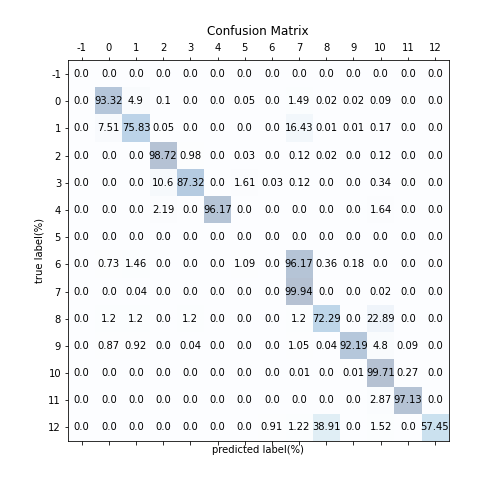

In [10]:
#@title <font color='yellow'>Confusion Matrix</font>
from IPython.display import display, HTML, clear_output

label = scClass.get_type_id(label=adata.obs[label_name].values,table=trans_table)

num_out = scClass.num_out
def confusion_matrix(y_pred,y_true,_filter=True):
    from sklearn.metrics import confusion_matrix
    import matplotlib.ticker as ticker
    if _filter:
        y_pred = y_pred[y_true>=0]
        y_true = y_true[y_true>=0]
    confmat = confusion_matrix(y_true=y_true, y_pred=y_pred,normalize="true",labels=range(-1,num_out))
    confmat = np.around(confmat*100, decimals=2)
    fig, ax = plt.subplots(figsize=(7, 7))
    ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(confmat.shape[0]):
        for j in range(confmat.shape[1]):
            ax.text(x=j, y=i, s=confmat[i,j], va='center', ha='center') 
    label2index = ['unknown','T-helper cell','cytotoxic T cell','memory B cell','naive B cell','plasma cell',\
              'precursor B cell','pro-B cell','natural killer cell','erythrocyte','megakaryocyte',\
              'monocyte','dendritic cell','BM hematopoietic cell']
    ax.xaxis.set_major_locator(ticker.FixedLocator(range(num_out+1)))
    ax.yaxis.set_major_locator(ticker.FixedLocator(range(num_out+1)))
    ax.set_xticklabels(range(-1,num_out))
    ax.set_yticklabels(range(-1,num_out))
    plt.title('Confusion Matrix')
    plt.xlabel('predicted label(%)')        
    plt.ylabel('true label(%)')
    plt.show()
    return fig
fig = confusion_matrix(y_pred=y_pred,y_true=label,_filter=True)
df = pd.DataFrame(['unknown','T-helper cell','cytotoxic T cell','memory B cell','naive B cell','plasma cell','precursor B cell','pro-B cell','natural killer cell','erythrocyte','megakaryocyte','monocyte','dendritic cell','BM hematopoietic cell'],index=range(-1,13),columns=['label'])
clear_output()
import base64
from io import BytesIO
tmpfile = BytesIO()
fig.savefig(tmpfile, format='png')
encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')
html_code = f'''
<div class="flex" style='display: flex;flex-direction: row;'>
  <div>
    <img src='data:image/png;base64,{encoded}'>
  </div> 
  <div>
    {df.to_html()}
  </div>
'''
HTML(html_code)

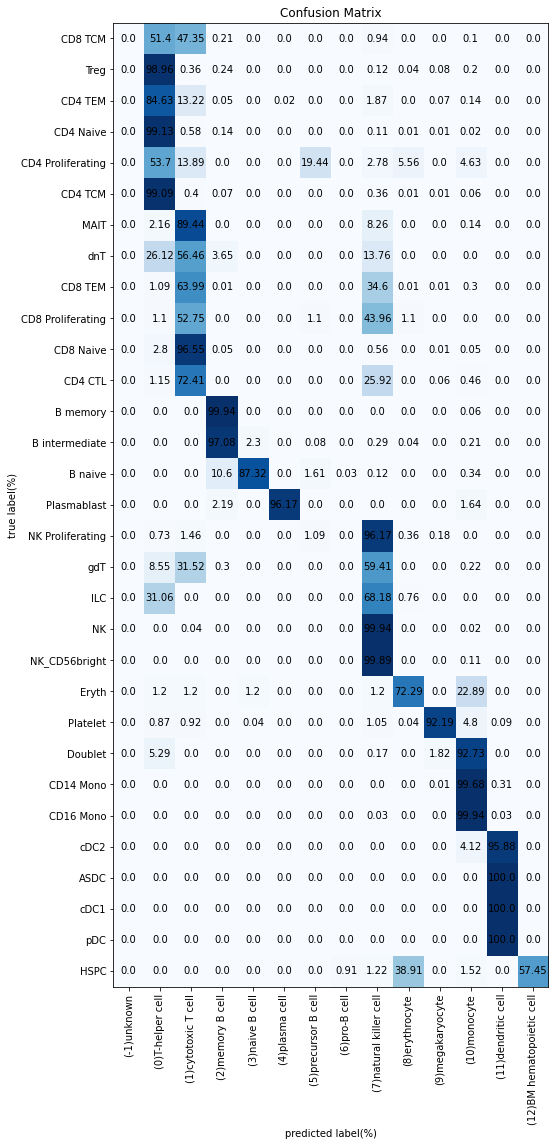

In [11]:
#@title <font color='yellow'>Heatmap Matrix</font>
scClass.heatmap_matrix(y_pred=y_pred,y_true=label2,label_y=label_y,table=trans_table)